In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/TimeSereisDatasets/EX-9/Copy of daily-website-visitors.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Unique.Visits'] = df['Unique.Visits'].str.replace(',', '').astype(int)
ts = df['Unique.Visits']

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts.values.reshape(-1, 1))

# Create time series samples
def create_dataset(data, look_back=14):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 14  # Using 14 days of history to predict next day
X, y = create_dataset(scaled_data, look_back)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [2]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0819 - val_loss: 0.0224
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0289 - val_loss: 0.0218
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0295 - val_loss: 0.0210
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0270 - val_loss: 0.0213
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0288 - val_loss: 0.0226
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0301 - val_loss: 0.0215
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0279 - val_loss: 0.0211
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0275 - val_loss: 0.0211


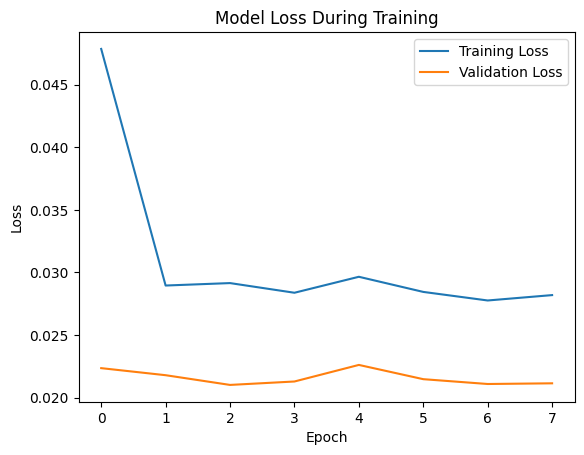

In [3]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train RMSE: 797.09
Test RMSE: 706.60


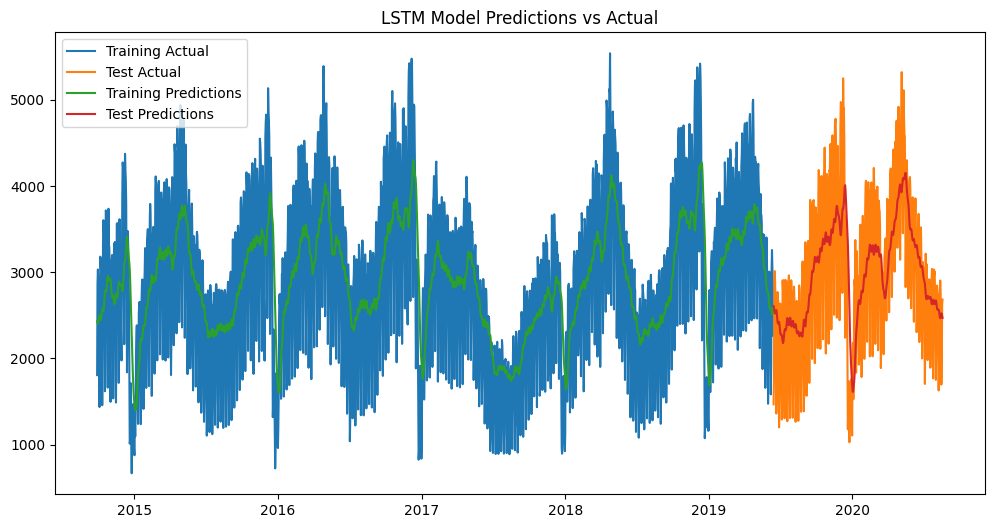

In [4]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(ts.index[look_back:train_size+look_back], y_train_actual, label='Training Actual')
plt.plot(ts.index[train_size+look_back:-1], y_test_actual, label='Test Actual')
plt.plot(ts.index[look_back:train_size+look_back], train_predict, label='Training Predictions')
plt.plot(ts.index[train_size+look_back:-1], test_predict, label='Test Predictions')
plt.title('LSTM Model Predictions vs Actual')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

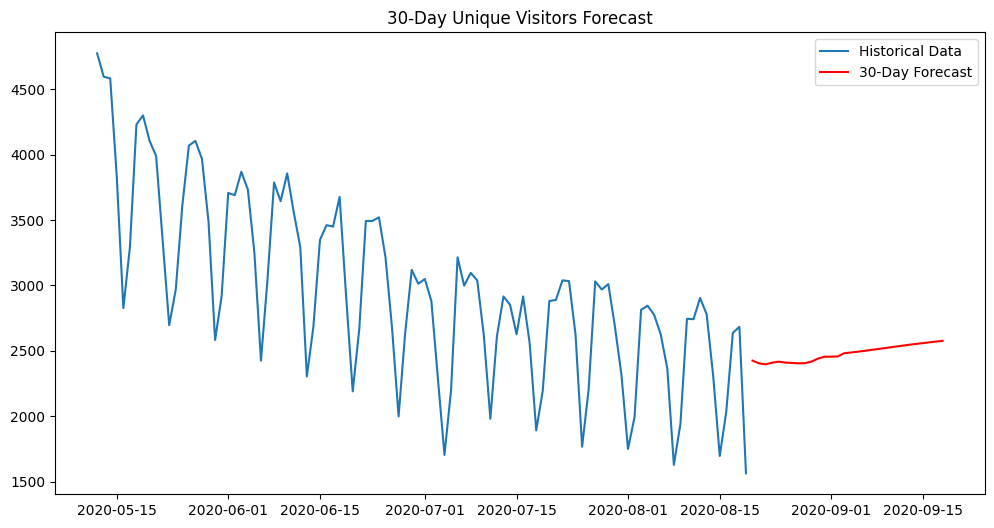

In [5]:
def forecast_future(model, last_sequence, n_steps):
    forecast = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Get prediction
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        forecast.append(next_pred[0,0])

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    return forecast

# Get last sequence from data
last_sequence = scaled_data[-look_back:]

# Forecast next 30 days
forecast_steps = 30
forecast_scaled = forecast_future(model, last_sequence, forecast_steps)
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create date index for forecast
forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(ts.index[-100:], ts.values[-100:], label='Historical Data')
plt.plot(forecast_dates, forecast, label='30-Day Forecast', color='red')
plt.title('30-Day Unique Visitors Forecast')
plt.legend()
plt.show()